In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler

In [35]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, acf, pacf
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [39]:
from scipy.signal import find_peaks

In [3]:
ssn = pd.read_csv('/Users/suryatejachalla/Projects/Solar-Data-Analysis/Data/processed/sunspot.csv')

ssn['date'] = pd.to_datetime(ssn[['year', 'month']].assign(DAY=1))
ssn = ssn.drop(columns=['year', 'month'], axis=1)
ssn.head()

,ssn,date
0,135.9,1749-07-01
1,137.9,1749-08-01
2,140.2,1749-09-01
3,143.8,1749-10-01
4,146.4,1749-11-01


In [4]:
tsi = pd.read_csv('/Users/suryatejachalla/Projects/Solar-Data-Analysis/Data/processed/tsi.csv')

tsi['date'] = pd.to_datetime(tsi[['year', 'month']].assign(DAY=1))
tsi = tsi.drop(columns=['year', 'month'], axis=1)
tsi.head()

,tsi,date
0,1363.841413,1947-08-01
1,1363.860329,1947-09-01
2,1363.898601,1947-10-01
3,1363.917975,1947-11-01
4,1363.884501,1947-12-01


In [5]:
ssn_tsi = pd.merge(ssn, tsi, on='date', how='inner')
ssn_tsi.head()

,ssn,date,tsi
0,210.9,1947-08-01,1363.841413
1,206.0,1947-09-01,1363.860329
2,206.3,1947-10-01,1363.898601
3,207.1,1947-11-01,1363.917975
4,205.7,1947-12-01,1363.884501


In [6]:
scaler = MinMaxScaler()

In [7]:
ssn_tsi[['ssn', 'tsi']] = scaler.fit_transform(ssn_tsi[['ssn', 'tsi']])
ssn_tsi.head()

,ssn,date,tsi
0,0.738347,1947-08-01,0.762371
1,0.721045,1947-09-01,0.777519
2,0.722105,1947-10-01,0.808167
3,0.724929,1947-11-01,0.823682
4,0.719986,1947-12-01,0.796876


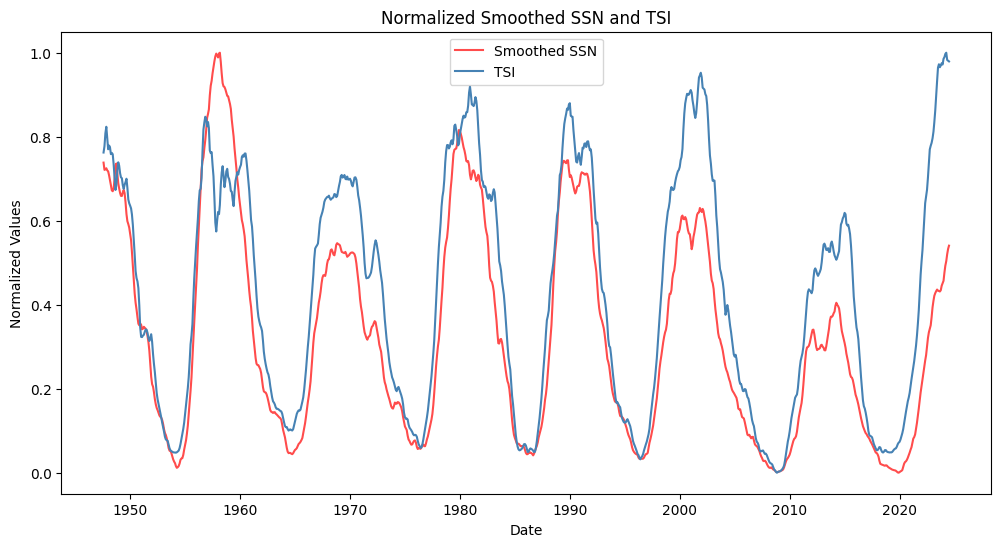

In [8]:
plt.figure(figsize=(12, 6))
plt.plot(ssn_tsi['date'], ssn_tsi['ssn'], label='Smoothed SSN', color='red', alpha=0.7)
plt.plot(ssn_tsi['date'], ssn_tsi['tsi'], label='TSI', color='steelblue')
plt.xlabel('Date')
plt.ylabel('Normalized Values')
plt.title('Normalized Smoothed SSN and TSI')
plt.legend()
plt.show()

## Correlation Analysis

In [9]:
correlation = ssn_tsi[['ssn', 'tsi']].corr()
print(correlation)

          ssn       tsi
ssn  1.000000  0.906481
tsi  0.906481  1.000000


In [10]:
from scipy.stats import pearsonr

corr_coef, p_value = pearsonr(ssn_tsi['ssn'], ssn_tsi['tsi'])
print(f"Pearson Correlation Coefficient: {corr_coef:.4f}")
print(f"P-value: {p_value:.4f}")

Pearson Correlation Coefficient: 0.9065
P-value: 0.0000


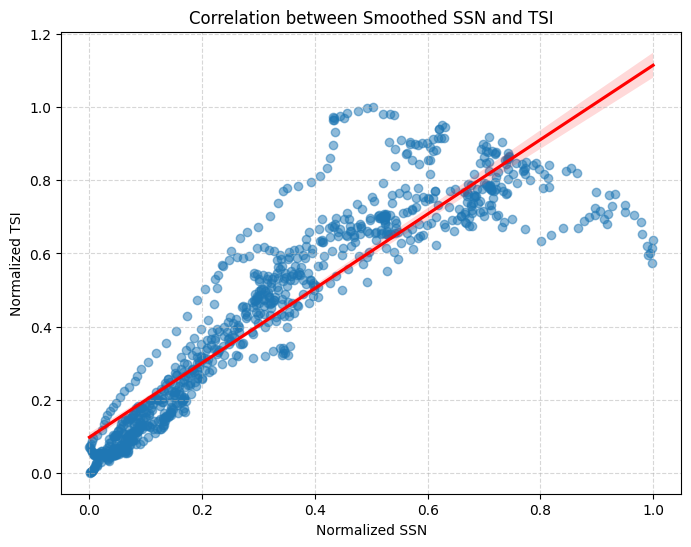

In [13]:
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.regplot(x=ssn_tsi['ssn'], y=ssn_tsi['tsi'], scatter_kws={'alpha':0.5}, line_kws={'color':'red'})
plt.xlabel('Normalized SSN')
plt.ylabel('Normalized TSI')
plt.title('Correlation between Smoothed SSN and TSI')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

In [15]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Compute VIF for each variable
X = ssn_tsi[['ssn', 'tsi']]
vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

vif_data

,Variable,VIF
0,ssn,14.73811
1,tsi,14.73811


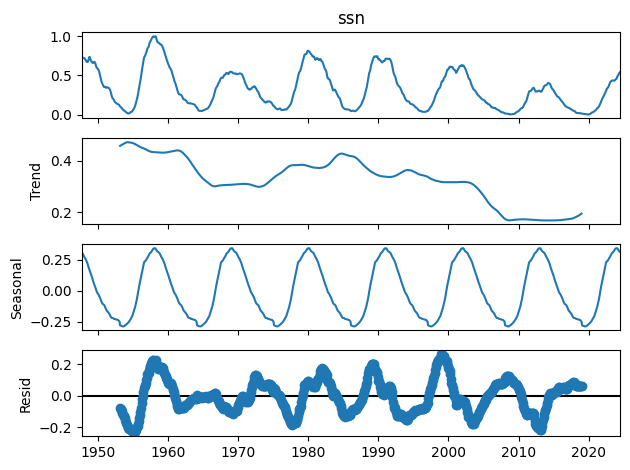

In [ ]:
# Perform decomposition
result = seasonal_decompose(ssn_tsi.set_index('date')['ssn'], model='additive', period=132)  # Assuming ~11-year solar cycle

# Plot decomposition
result.plot()
plt.show()

In [36]:
def check_stationarity(timeseries):
    result = adfuller(timeseries.dropna())
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))
    
    # If p-value is less than significance level (e.g., 0.05), 
    # we can reject the null hypothesis that the series has a unit root (is non-stationary)
    if result[1] <= 0.05:
        print("Conclusion: Series is stationary")
    else:
        print("Conclusion: Series is non-stationary")

In [37]:
check_stationarity(ssn_tsi['ssn'])
# Also check first difference to see if that becomes stationary
ssn_diff = ssn_tsi['ssn'].diff().dropna()
check_stationarity(ssn_diff)

ADF Statistic: -7.200723
p-value: 0.000000
Critical Values:
	1%: -3.438
	5%: -2.865
	10%: -2.568
Conclusion: Series is stationary
ADF Statistic: -4.733883
p-value: 0.000073
Critical Values:
	1%: -3.438
	5%: -2.865
	10%: -2.568
Conclusion: Series is stationary


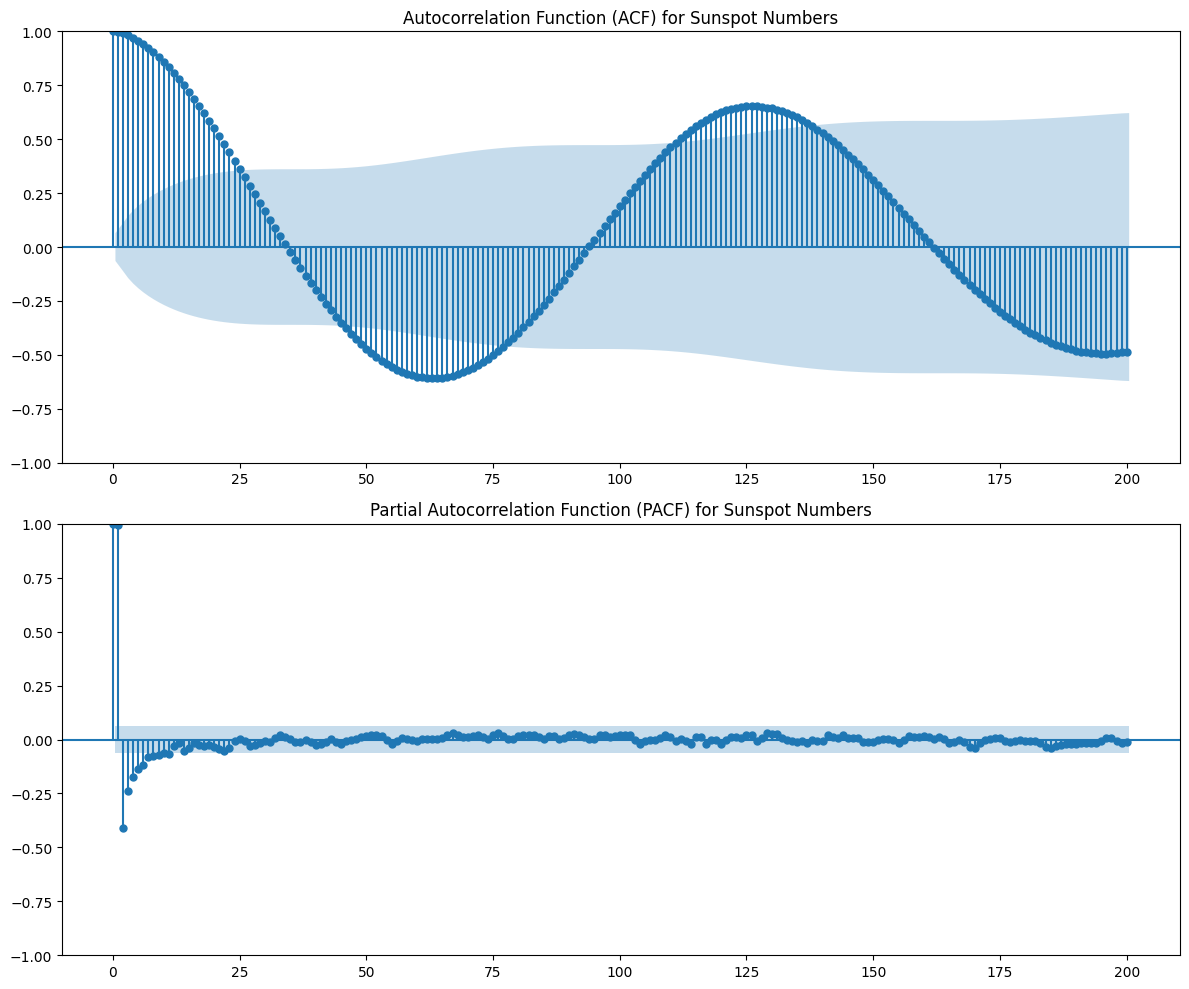

In [38]:
plt.figure(figsize=(12, 10))

plt.subplot(211)
plot_acf(ssn_tsi['ssn'].dropna(), lags=200, ax=plt.gca())
plt.title('Autocorrelation Function (ACF) for Sunspot Numbers')

plt.subplot(212)
plot_pacf(ssn_tsi['ssn'].dropna(), lags=200, ax=plt.gca())
plt.title('Partial Autocorrelation Function (PACF) for Sunspot Numbers')

plt.tight_layout()
plt.show()

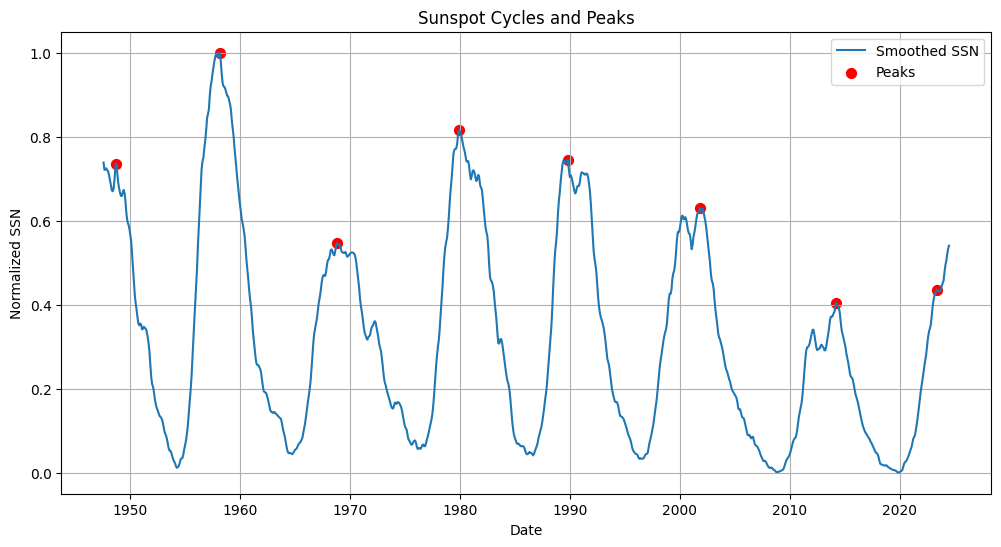

In [42]:
# Find peaks in the sunspot data
peaks, _ = find_peaks(ssn_tsi['ssn'], height=0.4, distance=100)  # Adjust parameters as needed
peak_dates = ssn_tsi.iloc[peaks]['date']
peak_values = ssn_tsi.iloc[peaks]['ssn']

plt.figure(figsize=(12, 6))
plt.plot(ssn_tsi['date'], ssn_tsi['ssn'], label='Smoothed SSN')
plt.scatter(peak_dates, peak_values, color='red', s=50, label='Peaks')
plt.xlabel('Date')
plt.ylabel('Normalized SSN')
plt.title('Sunspot Cycles and Peaks')
plt.legend()
plt.grid(True)
plt.show()